In [45]:
import librosa
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import pickle
import speechpy

In [44]:
!pip install speechpy

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan  2 21:46:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Model NN

Do Modelu NN można wprowadzać dane uśrednione oraz nieuśrednione

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [47]:
with open('/content/drive/MyDrive/Praca_Inżynierska_Dominik_Ossowski/Dane_Inżynierka_Dominik_Ossowski/extracted_features_soxr_hq_mean.df', 'rb') as file:
    extracted_features_copy_all = pickle.load(file)

In [48]:
extracted_features_copy_all

,features,genre
0,"[-66.780685, 64.261795, -9.776764, 11.287591, ...",Hip-Hop
1,"[-97.45645, 72.06718, -3.1508448, 29.252588, 5...",Hip-Hop
2,"[-106.024376, 86.379105, 13.008847, 23.29348, ...",Hip-Hop
3,"[-16.811268, 93.61206, -47.824642, 31.577908, ...",Pop
4,"[-83.644844, 83.572044, -1.5041039, 33.663593,...",Hip-Hop
...,...,...
24879,"[-249.6967, 151.92383, 2.2993913, 23.469448, 5...",Instrumental
24880,"[-171.556, 128.02463, 13.612911, 36.902237, 8....",Folk
24881,"[-217.11311, 161.97978, -1.1849602, 32.545143,...",Folk
24882,"[-167.28587, 86.76239, 7.620107, 18.808321, 8....",Experimental


In [68]:
with open('/content/drive/MyDrive/Praca_Inżynierska_Dominik_Ossowski/Dane_Inżynierka_Dominik_Ossowski/extracted_features_kaiser_fast_mean.df', 'rb') as file:
    extracted_features_copy_all = pickle.load(file)

In [69]:
extracted_features_copy_all

,features,genre
0,"[-73.994675, 74.43731, -19.873026, 21.252895, ...",Hip-Hop
1,"[-104.0215, 81.327934, -12.335339, 38.309357, ...",Hip-Hop
2,"[-112.37343, 95.33287, 4.1323757, 32.041306, -...",Hip-Hop
3,"[-23.45816, 102.98623, -57.12086, 40.74536, -1...",Pop
4,"[-89.662766, 92.05699, -9.912479, 41.94547, -2...",Hip-Hop
...,...,...
24879,"[-254.89601, 159.25215, -4.9546576, 30.599943,...",Instrumental
24880,"[-175.76717, 133.95882, 7.7439194, 42.662224, ...",Folk
24881,"[-219.19934, 164.92099, -4.099131, 35.414917, ...",Folk
24882,"[-173.01607, 94.84353, -0.39228395, 26.705832,...",Experimental


In [70]:
X=np.array(extracted_features_copy_all['features'].tolist())
y=np.array(extracted_features_copy_all['genre'])

In [71]:
X.shape

(24884, 13)

In [72]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [73]:
y.shape

(24884, 14)

In [74]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [76]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)
print(y_train.shape)

(17916, 13)
(2489, 13)
(4479, 13)
(17916, 14)


In [77]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_validation)

In [78]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(X_valid_scaled.shape)

(17916, 13)
(2489, 13)
(4479, 13)


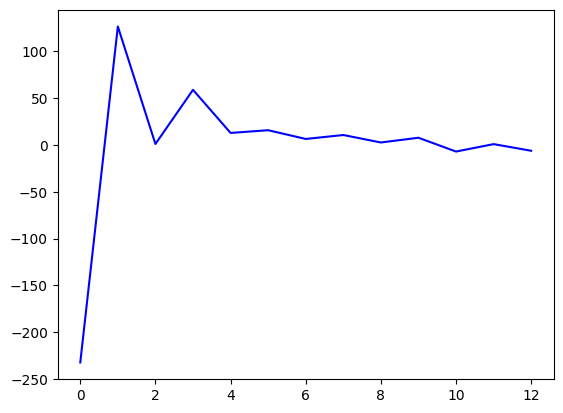

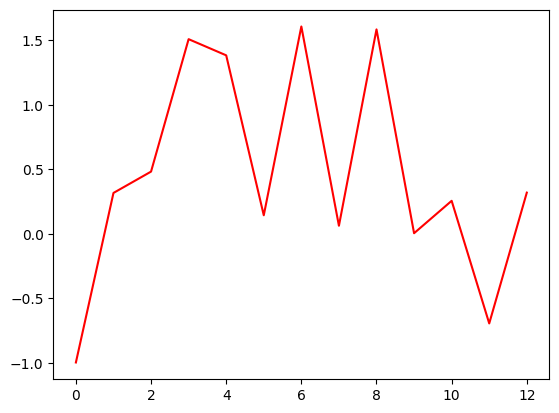

In [79]:
plt.plot(X_train[0], 'b-')
plt.figure()
plt.plot(X_train_scaled[0], 'r-')

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [14]:
!pip3 install --upgrade tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [81]:
model=Sequential()
#model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(512,kernel_regularizer=tf.keras.regularizers.L2(0.001),input_shape=(13,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(256,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(14))
model.add(Activation('softmax'))

In [80]:
model.save('sorx_hq_mean_NN.keras')

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               7168      
                                                                 
 batch_normalization_15 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 512)               0         
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_16 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [83]:
#from keras.engine.training import optimizer
num_epochs = 80
num_batch_size = 16

checkpointer = ModelCheckpoint(filepath='/content/sample_data', save_best_only=True,verbose=1)

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tfa.metrics.F1Score(num_classes=14,
                                                  average='micro',
                                                  threshold=0.5)])



In [ ]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
 # raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [84]:
#with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, y_validation), callbacks=[checkpointer],verbose=1)

Epoch 1/80
1113/1120 [============================>.] - ETA: 0s - loss: 3.0857 - accuracy: 0.2398 - f1_score: 0.1346
Epoch 1: val_loss improved from inf to 2.36041, saving model to /content/sample_data
1120/1120 [==============================] - 11s 8ms/step - loss: 3.0830 - accuracy: 0.2403 - f1_score: 0.1350 - val_loss: 2.3604 - val_accuracy: 0.4307 - val_f1_score: 0.2700
Epoch 2/80
1113/1120 [============================>.] - ETA: 0s - loss: 2.6563 - accuracy: 0.3423 - f1_score: 0.2503
Epoch 2: val_loss improved from 2.36041 to 2.21821, saving model to /content/sample_data
1120/1120 [==============================] - 9s 8ms/step - loss: 2.6573 - accuracy: 0.3420 - f1_score: 0.2499 - val_loss: 2.2182 - val_accuracy: 0.4505 - val_f1_score: 0.3538
Epoch 3/80
1112/1120 [============================>.] - ETA: 0s - loss: 2.4897 - accuracy: 0.3725 - f1_score: 0.2748
Epoch 3: val_loss improved from 2.21821 to 2.15544, saving model to /content/sample_data
1120/1120 [========================

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [87]:
def predict(model, X, y):

    X = X[np.newaxis, ...]

    # perform prediction
    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)

    p = np.argmax(y, axis=0)

    print("Target: {}, Predicted label: {}".format(p, predicted_index))


In [ ]:
X_to_predict = X_test[151]
y_to_predict = y_test[151]

predict(model, X_to_predict, y_to_predict)

In [ ]:
dict(zip(labelencoder.classes_,range(len(labelencoder.classes_))))

{'Blues': 0,
 'Classical': 1,
 'Country': 2,
 'Easy Listening': 3,
 'Electronic': 4,
 'Experimental': 5,
 'Folk': 6,
 'Hip-Hop': 7,
 'Instrumental': 8,
 'International': 9,
 'Jazz': 10,
 'Old-Time / Historic': 11,
 'Pop': 12,
 'Rock': 13,
 'Soul-RnB': 14,
 'Spoken': 15}

In [89]:
test_loss, test_acc, *is_anything_else_being_returned = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

78/78 - 0s - loss: 1.5318 - accuracy: 0.5227 - f1_score: 0.4245 - 184ms/epoch - 2ms/step

Test accuracy: 0.5226998925209045


Aby poprawić działanie modeli zastosuję(dotyczy NN oraz CNN):


1.   dropout albo batch normalization zamiennie
2.   dostrojenie hiperparametrów(regularyzacji, learning rate, podziału na train test valid, prawdopodobieństwo dropoutu, dodać stratyfikacje)
3. cross validation
3. zwiększenie ilości neuronów i warstw w sieci
5. usunięcie niezbalansowanych klas
5. data augmentation
6. zwiększyć ilość mfccs

